<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import random
from collections import Counter
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import itertools
from scipy.stats import wilcoxon
import seaborn as sns

### Algoritmos

In [ ]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    X_columns = dataframe.columns[dataframe.columns != 'Classe']
    X = dataframe[X_columns]
    Y = dataframe['Classe']

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [ ]:
def BlockSplit0(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [ ]:
def BlockSplit(dataframe, seed, n_songs):


  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  #used_list = []
  range_list = []
  block_lists = []

  for i in range(10):
    range_list.append(range(i*songs_per_genre, (i+1)*songs_per_genre))

  for k in range(10):
    test_list = []
    definitive_test_list = []

    for i in range(10):
      r = random.sample(range_list[i], n_test)
      # print(range_list[i])
      range_list[i] = [element for element in range_list[i] if element not in r]

      for j in r:
        test_list.append(j)

    test_list.sort()
    # print(test_list)
    for i in test_list:
      for j in range(n_block):
        definitive_test_list.append(round((i*n_block)+j))

    # print(definitive_test_list)
    block_lists.append(definitive_test_list)

  return block_lists

In [ ]:
def blockBalancedScore(Y_real, Y_predict, n_songs):

  #print(type(Y_real))

  n_samples = len(Y_predict)
  samples_per_song = (n_samples*10)/n_songs

  block_predict = []
  block_true = []

  # print('N_songs:', n_songs)
  # print('N_samples:', len(Y_predict))
  # print('samples_per_song:', samples_per_song)

  predict_groups = [Y_predict[i:i+int(samples_per_song)] for i in range(0, n_samples, int(samples_per_song))]

  for group in predict_groups:
    count = Counter(group)
    block_predict.append(count.most_common(1)[0][0])

  indexes = range(0, n_samples, int(samples_per_song))
  block_true = Y_real.iloc[indexes].tolist()

  return balanced_accuracy_score(block_true, block_predict)

In [ ]:
def elbowKNN(dflist, n_neigh, seed, n_songs):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = neigh.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [ ]:
def elbowTree(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = clf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [ ]:
def elbowRF(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = rf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [ ]:
def elbowAll(dflist, seed, n_songs):
  scorelistKNN = []
  scorelistDT = []
  scorelistRF = []
  scorelistSVM = []
  scorelistXGB = []
  scorelistMLP = []
  scorelistLR = []

  scorelistKNNB = []
  scorelistDTB = []
  scorelistRFB = []
  scorelistSVMB = []
  scorelistXGBB = []
  scorelistMLPB = []
  scorelistLRB = []

  for df in dflist:


    scorelistKNN_t = []
    scorelistDT_t = []
    scorelistRF_t = []
    scorelistSVM_t = []
    scorelistXGB_t = []
    scorelistMLP_t = []
    scorelistLR_t = []

    scorelistKNNB_t = []
    scorelistDTB_t = []
    scorelistRFB_t = []
    scorelistSVMB_t = []
    scorelistXGBB_t = []
    scorelistMLPB_t = []
    scorelistLRB_t = []


    df['Classe'] = pd.Categorical(df['Classe'])
    df['Classe'] = df['Classe'].cat.codes

    neigh = neighbors.KNeighborsClassifier()
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=12,
                                      min_samples_leaf=2, min_samples_split=2,
                                      random_state = seed)
    rf = ensemble.RandomForestClassifier(random_state = seed)
    svmc = svm.SVC(random_state=seed)
    xgbc = xgb.XGBClassifier(objective='multi:softprob', random_state=seed)
    mlp = MLPClassifier(random_state=seed)
    lr = LogisticRegression(random_state=seed, max_iter=300)

    test_list = BlockSplit(df, seed = seed, n_songs=n_songs)
    scaler = MinMaxScaler()

    # print(test_list)

    #df = df.drop(columns=['tempo1', 'tempo2', 'tempo3'])
    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]

    X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)

    Y = df['Classe']

    for test in test_list:

      # print(test)
      # print(display(X.head()))
      # print(display(Y.head()))


      neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predict3 = neigh.predict(X.iloc[X.index.isin(test),:])

      clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictDT = clf.predict(X.iloc[X.index.isin(test),:])

      rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictRF = rf.predict(X.iloc[X.index.isin(test),:])

      svmc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictSVM = svmc.predict(X.iloc[X.index.isin(test),:])

      xgbc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictXGB = xgbc.predict(X.iloc[X.index.isin(test),:])

      mlp.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictMLP = mlp.predict(X.iloc[X.index.isin(test),:])

      lr.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictLR = lr.predict(X.iloc[X.index.isin(test),:])


      scorelistKNN_t.append(balanced_accuracy_score(Y.iloc[test], Y_predict3))
      scorelistDT_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictDT))
      scorelistRF_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictRF))
      scorelistSVM_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictSVM))
      scorelistXGB_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictXGB))
      scorelistMLP_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictMLP))
      scorelistLR_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictLR))

      scorelistKNNB_t.append(blockBalancedScore(Y.iloc[test], Y_predict3, n_songs))
      scorelistDTB_t.append(blockBalancedScore(Y.iloc[test], Y_predictDT, n_songs))
      scorelistRFB_t.append(blockBalancedScore(Y.iloc[test], Y_predictRF, n_songs))
      scorelistSVMB_t.append(blockBalancedScore(Y.iloc[test], Y_predictSVM, n_songs))
      scorelistXGBB_t.append(blockBalancedScore(Y.iloc[test], Y_predictXGB, n_songs))
      scorelistMLPB_t.append(blockBalancedScore(Y.iloc[test], Y_predictMLP, n_songs))
      scorelistLRB_t.append(blockBalancedScore(Y.iloc[test], Y_predictLR, n_songs))

    scorelistKNN.append(np.mean(scorelistKNN_t, axis=0))
    scorelistDT.append(np.mean(scorelistDT_t, axis=0))
    scorelistRF.append(np.mean(scorelistRF_t, axis=0))
    scorelistSVM.append(np.mean(scorelistSVM_t, axis=0))
    scorelistXGB.append(np.mean(scorelistXGB_t, axis=0))
    scorelistMLP.append(np.mean(scorelistMLP_t, axis=0))
    scorelistLR.append(np.mean(scorelistLR_t, axis=0))

    scorelistKNNB.append(np.mean(scorelistKNNB_t, axis=0))
    scorelistDTB.append(np.mean(scorelistDTB_t, axis=0))
    scorelistRFB.append(np.mean(scorelistRFB_t, axis=0))
    scorelistSVMB.append(np.mean(scorelistSVMB_t, axis=0))
    scorelistXGBB.append(np.mean(scorelistXGBB_t, axis=0))
    scorelistMLPB.append(np.mean(scorelistMLPB_t, axis=0))
    scorelistLRB.append(np.mean(scorelistLRB_t, axis=0))



  return scorelistKNN, scorelistDT, scorelistRF, scorelistSVM, scorelistXGB, scorelistMLP, scorelistLR, scorelistKNNB, scorelistDTB, scorelistRFB, scorelistSVMB, scorelistXGBB, scorelistMLPB, scorelistLRB

In [ ]:
def runXGB(dflist, seed, n_songs):

  scorelistXGB = []
  xgb_matrix = np.zeros((10,10))
  feat_import = np.zeros((76))

  for df in dflist:

    scorelistXGB_t = []

    df['Classe'] = pd.Categorical(df['Classe'])
    df['Classe'] = df['Classe'].cat.codes

    xgbc = xgb.XGBClassifier(objective='multi:softprob', random_state=seed)

    test_list = BlockSplit(df, seed = seed, n_songs=n_songs)
    scaler = MinMaxScaler()

    # print(test_list)

    df = df.drop(columns=['tempo'])
    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]

    X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)

    Y = df['Classe']

    for test in test_list:

      xgbc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictXGB = xgbc.predict(X.iloc[X.index.isin(test),:])

      scorelistXGB_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictXGB))

      xgb_matrix += confusion_matrix(Y.iloc[test], Y_predictXGB)
      feat_import+= xgbc.feature_importances_


    scorelistXGB.append(np.mean(scorelistXGB_t, axis=0))
    feat_import = feat_import/10

  return scorelistXGB, xgb_matrix, feat_import

### Testes

In [ ]:
#Ler CSVs
dflist = []

csvnames = ['2048.csv']

for i in csvnames:
  dir_path = os.path.join('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [ ]:
dflist[0].head()

,Chroma mean C,Chroma sd2 C,Chroma mean C#,Chroma sd2 C#,Chroma mean D,Chroma sd2 D,Chroma mean D#,Chroma sd2 D#,Chroma mean E,Chroma sd2 E,...,MFCC17 mean,MFCC17 sd2,MFCC18 mean,MFCC18 sd2,MFCC19 mean,MFCC19 sd2,MFCC20 mean,MFCC20 sd2,tempo,Classe
0,0.394617,0.105338,0.443642,0.088150,0.481578,0.101544,0.346441,0.061531,0.370519,0.082360,...,5.050471,36.993397,-8.289567,33.612530,-2.478076,38.674590,-2.092990,34.718590,123.046875,blues
1,0.428290,0.113275,0.476215,0.106603,0.494223,0.107198,0.379621,0.076511,0.357802,0.066731,...,6.498300,29.181923,-3.217815,54.156834,3.200929,68.362210,0.460429,26.820696,123.046875,blues
2,0.357212,0.096538,0.378870,0.071623,0.492932,0.101273,0.352712,0.061301,0.321471,0.066488,...,4.673268,32.282803,-7.692242,36.558690,0.692331,38.365930,0.794478,35.058080,123.046875,blues
3,0.395143,0.086771,0.413099,0.078591,0.496900,0.105141,0.345685,0.054382,0.359460,0.067951,...,4.546683,32.767582,-5.488396,24.877170,1.453244,28.945955,-0.223831,27.314598,129.199219,blues
4,0.405898,0.121835,0.433755,0.109411,0.463097,0.106878,0.305630,0.067156,0.281570,0.061102,...,5.317678,26.526995,-4.582438,36.219418,2.514524,36.389427,-0.436270,27.635517,123.046875,blues


In [ ]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores = []
dtscores = []
rfscores = []
svmscores = []
xgbscores = []
mlpscores = []
lrscores = []

knnscoresB = []
dtscoresB = []
rfscoresB = []
svmscoresB = []
xgbscoresB = []
mlpscoresB = []
lrscoresB = []

seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]
# seeds = [14, 42, 60]


# for seed in seeds:
#   knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed, n_songs=500))
#   knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed, n_songs=500))
#   knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed, n_songs=500))

#   dtscores.append(elbowTree(dflist, seed = seed, n_songs=500))
#   rfscores.append(elbowRF(dflist, seed = seed, n_songs=500))

for seed in seeds:
  knn, dt, rf, svmc, xgbc, mlp, lr, knnB, dtB, rfB, svmcB, xgbcB, mlpB, lrB = elbowAll(dflist, seed = seed, n_songs=1000)

  knnscores.append(knn)
  dtscores.append(dt)
  rfscores.append(rf)
  svmscores.append(svmc)
  xgbscores.append(xgbc)
  mlpscores.append(mlp)
  lrscores.append(lr)

  knnscoresB.append(knnB)
  dtscoresB.append(dtB)
  rfscoresB.append(rfB)
  svmscoresB.append(svmcB)
  xgbscoresB.append(xgbcB)
  mlpscoresB.append(mlpB)
  lrscoresB.append(lrB)

C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

In [ ]:
#lendo a cnn
cnn_results = pd.read_pickle("C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/results/performances_vgg16_50.pkl")

In [ ]:
cnn_results.head()

,bac,seed,conf_matrix
0,0.661500,14,"[[410.0, 9.0, 43.0, 26.0, 6.0, 31.0, 10.0, 1.0..."
1,0.665167,42,"[[403.0, 6.0, 26.0, 33.0, 6.0, 42.0, 3.0, 1.0,..."
2,0.643667,60,"[[345.0, 7.0, 28.0, 45.0, 13.0, 63.0, 11.0, 0...."
3,0.656500,87,"[[423.0, 9.0, 16.0, 53.0, 27.0, 25.0, 6.0, 0.0..."
4,0.657000,113,"[[338.0, 8.0, 29.0, 47.0, 21.0, 52.0, 8.0, 1.0..."


In [ ]:
def get_random_results(seeds):
  classes = ["Blues", "Classical", "Country", "Disco", "Hip Hop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
  y_true = np.repeat(classes, 60)

  bac = []

  for seed in seeds:
    np.random.seed(seed)
    y = np.random.choice(classes, 600)
    bac.append(balanced_accuracy_score(y_true, y))

  return np.array(bac)

In [ ]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslistB = []
scoresmeansB = []
scoressdsB = []

scoreslist.append(np.array(knnscores))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))
scoreslist.append(np.array(svmscores))
scoreslist.append(np.array(xgbscores))
scoreslist.append(np.array(mlpscores))
scoreslist.append(np.array(lrscores))
scoreslist.append(cnn_results['bac'].values)
scoreslist.append(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))
scoreslist.append(get_random_results(seeds))


# scoreslistB.append(np.array(knnscoresB))
# scoreslistB.append(np.array(dtscoresB))
# scoreslistB.append(np.array(rfscoresB))
# scoreslistB.append(np.array(svmscoresB))
# scoreslistB.append(np.array(xgbscoresB))
# scoreslistB.append(np.array(mlpscoresB))
# scoreslistB.append(np.array(lrscoresB))


# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

# for score in scoreslistB:
#   scoresmeansB.append(np.mean(score, axis=0))
#   scoressdsB.append(np.std(score, axis=0))

In [ ]:
np.mean(get_random_results(seeds))

0.10383333333333333

In [ ]:
scoreslist = scoreslist[:8]
scoresmeans = scoresmeans[:8]
scoressds = scoressds[:8]

In [ ]:
scoreslist2 = []
for score in scoreslist:
  scoreslist2.append(score.flatten())

scoreslist2

[array([0.613     , 0.61633333, 0.62216667, 0.61416667, 0.61866667,
        0.61666667, 0.61483333, 0.61683333, 0.611     , 0.62266667]),
 array([0.49616667, 0.51566667, 0.5125    , 0.506     , 0.49866667,
        0.50666667, 0.5095    , 0.497     , 0.4935    , 0.4995    ]),
 array([0.68866667, 0.68933333, 0.69      , 0.68666667, 0.68583333,
        0.68333333, 0.68533333, 0.691     , 0.689     , 0.691     ]),
 array([0.68516667, 0.693     , 0.69266667, 0.687     , 0.68516667,
        0.68916667, 0.6955    , 0.6905    , 0.686     , 0.69166667]),
 array([0.719     , 0.72183333, 0.72      , 0.723     , 0.72316667,
        0.72366667, 0.72733333, 0.72516667, 0.7145    , 0.72333333]),
 array([0.686     , 0.69416667, 0.699     , 0.69766667, 0.692     ,
        0.69683333, 0.69583333, 0.69533333, 0.69516667, 0.69733333]),
 array([0.66516667, 0.6705    , 0.66983333, 0.66433333, 0.66466667,
        0.66533333, 0.66916667, 0.66616667, 0.666     , 0.669     ]),
 array([0.6615    , 0.66516667, 0.

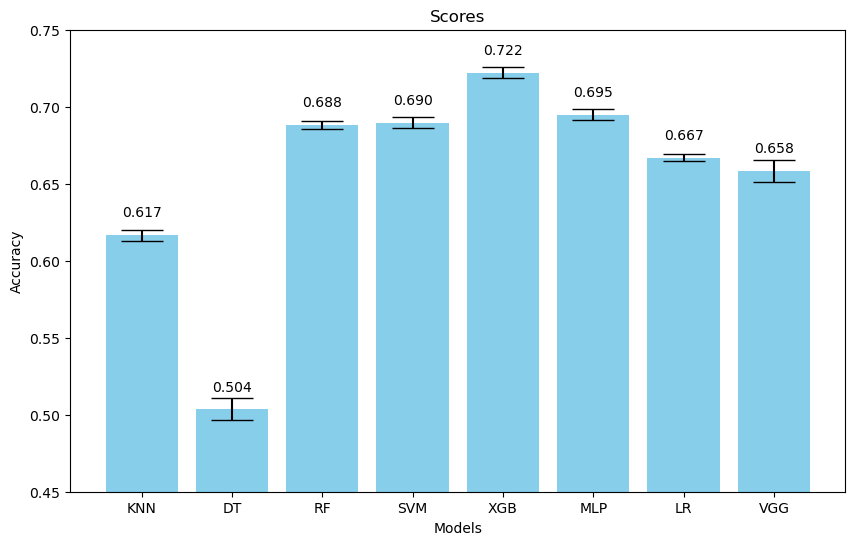

In [ ]:
medias = [arr.item() for arr in scoresmeans]
desvios = [arr.item() for arr in scoressds]


labels = ['KNN', 'DT', 'RF', 'SVM', 'XGB', 'MLP', 'LR', 'VGG']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, medias, yerr=desvios, capsize=15, color='skyblue')

for bar, media in zip(bars, medias):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{media:.3f}', ha='center', va='bottom', fontsize=10)

# Adicionando títulos e rótulos
plt.ylim([0.45, 0.75])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Scores')

plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/results.pdf')
plt.show()

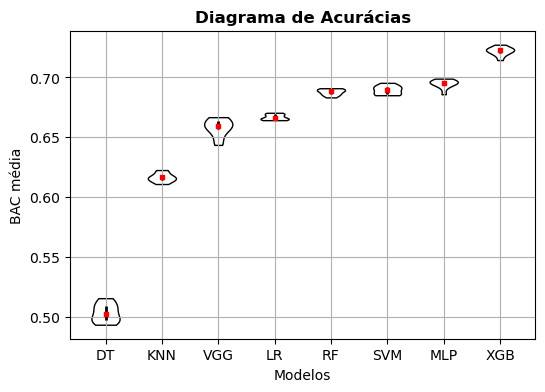

In [ ]:
labels = ['KNN', 'DT', 'RF', 'SVM', 'XGB', 'MLP', 'LR', 'VGG']
sorted_indices = np.argsort(medias)

sorted_scores = [scoreslist2[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

plt.figure(figsize=(6, 4))
# plt.boxplot(sorted_scores, labels=sorted_labels, patch_artist=False, notch=False, widths=0.8)

parts = plt.violinplot(sorted_scores, showmeans=False, showmedians=False, showextrema=False)

# Customizar a aparência do gráfico
for pc in parts['bodies']:
    pc.set_facecolor('white')       # Preencher com branco
    pc.set_edgecolor('black')       # Contorno preto
    pc.set_linewidth(1)             # Espessura do contorno
    pc.set_alpha(1)                 # Sem transparência

# Adicionar as medianas
quartile1, medians, quartile3 = np.percentile(sorted_scores, [25, 50, 75], axis=1)
inds = np.arange(1, len(medians) + 1)

plt.scatter(inds, medians, marker='s', color='red', s=10, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=2)

# Adicionar as labels
plt.xticks(ticks=range(1, len(sorted_labels) + 1), labels=sorted_labels)

# Adicionando títulos e rótulos
plt.title('Diagrama de Acurácias', fontweight = 'bold')
plt.xlabel('Modelos')
plt.ylabel('BAC média')
plt.grid(True)

# Exibindo o gráfico
plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/04_violin_ptg.pdf')
plt.show()

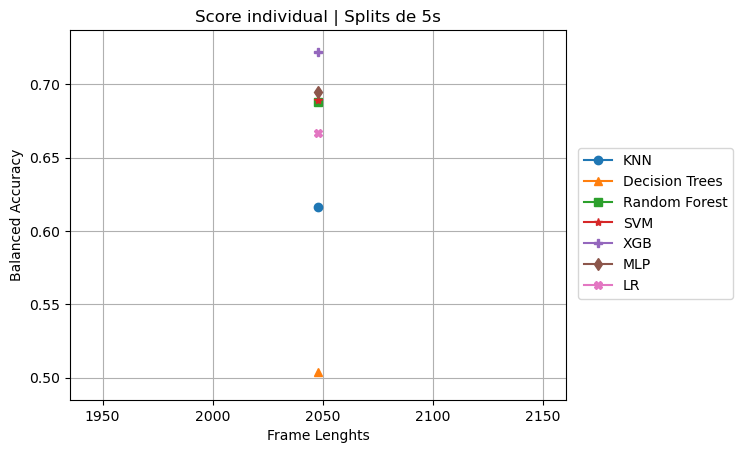

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [2048]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.15)

plt.legend( bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Score individual | Splits de 5s')

# Nome do arquivo pra salvar
plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/results.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: 'F:/Documentos/UTFPR/IC/csvs/ft2/10s/score_bloco_st.pdf'

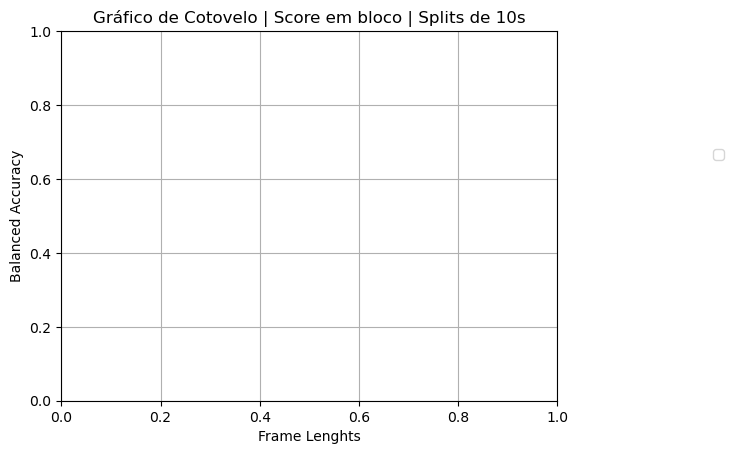

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeansB)):
  plt.plot(frame_lenghts, scoresmeansB[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeansB[i] + scoressdsB[i], scoresmeansB[i] - scoressdsB[i], alpha = 0.15)

plt.legend(bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo | Score em bloco | Splits de 10s')

# Nome do arquivo pra salvar
plt.savefig('F:/Documentos/UTFPR/IC/csvs/ft2/10s/score_bloco_st.pdf')
plt.show()

In [ ]:
means_3s_ind = []
means_3s_ind.append(scoresmeans)
means_3s_b = []
means_3s_b.append(scoresmeansB)

In [ ]:
print(means_3s_b)
print(means_3s_ind)
print(means_5s_ind)
print(means_5s_b)
print(means_10s_ind)
print(means_10s_b)

[[array([0.7  , 0.699, 0.698, 0.704, 0.699, 0.705]), array([0.606, 0.587, 0.624, 0.59 , 0.629, 0.63 ]), array([0.74 , 0.736, 0.743, 0.746, 0.727, 0.735]), array([0.754, 0.753, 0.753, 0.751, 0.744, 0.751]), array([0.779, 0.782, 0.786, 0.79 , 0.784, 0.777]), array([0.754, 0.767, 0.767, 0.769, 0.764, 0.769]), array([0.721, 0.725, 0.728, 0.728, 0.734, 0.743])]]
[[array([0.574 , 0.5721, 0.5731, 0.5783, 0.5803, 0.5741]), array([0.4748, 0.4656, 0.4843, 0.4775, 0.4896, 0.487 ]), array([0.6687, 0.6658, 0.6739, 0.6725, 0.6667, 0.6674]), array([0.6789, 0.6786, 0.6792, 0.6839, 0.6791, 0.6859]), array([0.7009, 0.7015, 0.7112, 0.7134, 0.7041, 0.7063]), array([0.6843, 0.6847, 0.6847, 0.6868, 0.687 , 0.691 ]), array([0.6595, 0.6605, 0.6591, 0.6605, 0.6596, 0.6674])]]
[[array([0.60533333, 0.60533333, 0.60783333, 0.61783333, 0.61216667,
       0.613     ]), array([0.491     , 0.48966667, 0.496     , 0.49566667, 0.49883333,
       0.50133333]), array([0.679     , 0.681     , 0.68533333, 0.69066667, 0.681

In [ ]:
ind_3s = [elemento for array in means_3s_ind[0] for elemento in array]
b_3s = [elemento for array in means_3s_b[0] for elemento in array]

ind_5s = [elemento for array in means_5s_ind[0] for elemento in array]
b_5s = [elemento for array in means_5s_b[0] for elemento in array]

ind_10s = [elemento for array in means_10s_ind[0] for elemento in array]
b_10s = [elemento for array in means_10s_b[0] for elemento in array]


NameError: name 'means_3s_ind' is not defined

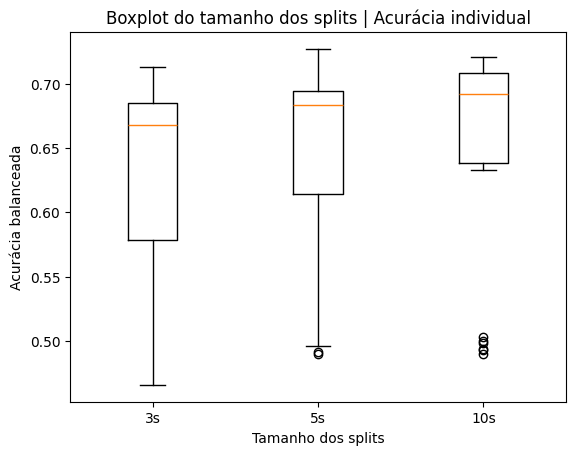

In [ ]:
plt.boxplot([ind_3s, ind_5s, ind_10s], labels=["3s", "5s", "10s"])
plt.xlabel("Tamanho dos splits")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho dos splits | Acurácia individual")
plt.savefig('boxplot_splits.pdf')
plt.show()

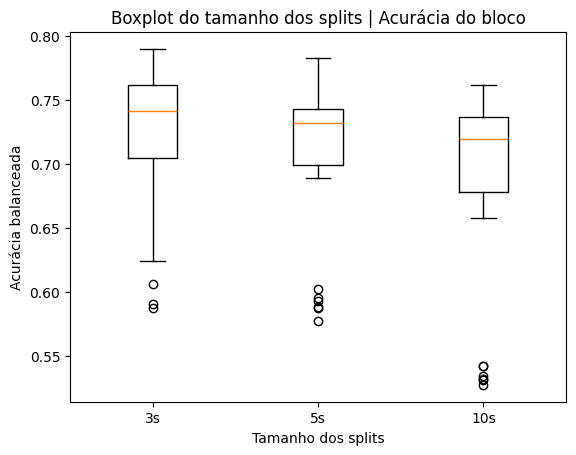

In [ ]:
plt.boxplot([b_3s, b_5s, b_10s], labels=["3s", "5s", "10s"])
plt.xlabel("Tamanho dos splits")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho dos splits | Acurácia do bloco")
plt.savefig('boxplot_splits_b.pdf')
plt.show()

In [ ]:
fls_ind = [[lista[i] for lista in means_3s_ind[0]] for i in range(6)]
fls_b = [[lista[i] for lista in means_3s_b[0]] for i in range(6)]

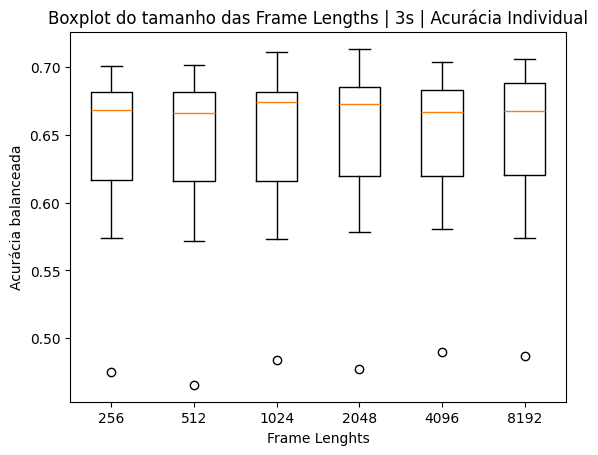

In [ ]:
plt.boxplot(fls_ind, labels=["256", "512", "1024", "2048", "4096", "8192"])
plt.xlabel("Frame Lenghts")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho das Frame Lengths | 3s | Acurácia Individual")
plt.savefig('boxplot_fl3.pdf')
plt.show()

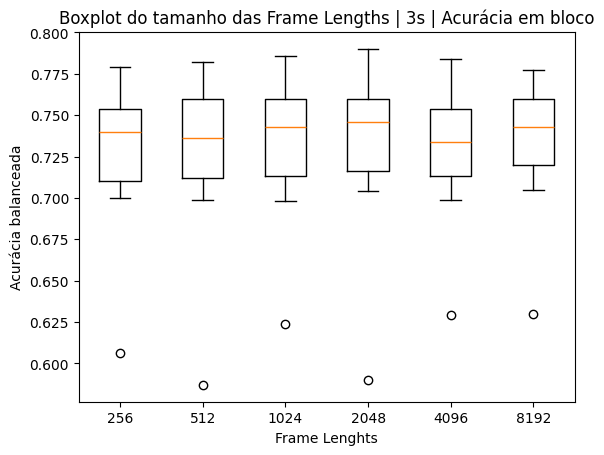

In [ ]:
plt.boxplot(fls_b, labels=["256", "512", "1024", "2048", "4096", "8192"])
plt.xlabel("Frame Lenghts")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho das Frame Lengths | 3s | Acurácia em bloco")
plt.savefig('boxplot_fl3b.pdf')
plt.show()

In [ ]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(np.array(ind_3s), np.array(ind_5s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 3s - 5s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 3s - 5s: 0.0
Valor p: 4.547473508864641e-13
Há evidência estatística de diferença significativa.


In [ ]:

statistic, p_value = wilcoxon(np.array(ind_3s), np.array(ind_10s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 3s - 10s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 3s - 10s: 0.0
Valor p: 4.547473508864641e-13
Há evidência estatística de diferença significativa.


In [ ]:

statistic, p_value = wilcoxon(np.array(ind_5s), np.array(ind_10s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 5s - 10s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 5s - 10s: 38.0
Valor p: 3.6529109078762475e-07
Há evidência estatística de diferença significativa.


In [ ]:
dfbox = pd.DataFrame({'3s individual': ind_3s, '5s individual': ind_5s, '10s individual': ind_10s, '3s em bloco': b_3s, '5s em bloco': b_5s, '10s em bloco': b_10s})

In [ ]:
dfbox.head()
dfbox.to_csv('boxplot_values.csv', index=False)

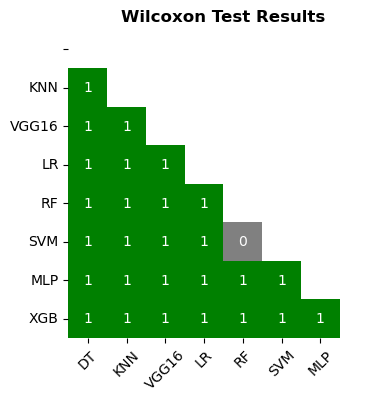

In [ ]:


acc_list = np.array(sorted_scores)
acc_list.shape

num_algorithms = acc_list.shape[0]
alpha = 0.05

significance_matrix = np.full((num_algorithms, num_algorithms), False, dtype=bool)

# Realiza o teste de Wilcoxon para todas as combinações 2 a 2 de algoritmos
for i, j in itertools.combinations(range(num_algorithms), 2):
    stat, p = wilcoxon(acc_list[i], acc_list[j])
    if p < alpha:
        significance_matrix[i, j] = True
        significance_matrix[j, i] = True  # A matriz é simétrica

# Converte a matriz de significância para inteiros (True -> 1, False -> 0)
significance_matrix_int = significance_matrix.astype(int)

# Define os nomes dos algoritmos
algorithms = sorted_labels

# Cria uma máscara para o triângulo superior
mask = np.triu(np.ones_like(significance_matrix_int, dtype=bool))

# Configura o tamanho da figura
plt.figure(figsize=(4, 4))

alg2 = sorted_labels.copy()
alg2[0] = ' '

# Cria o heatmap triangular
cmap = sns.color_palette(["gray", "green"])
sns.heatmap(significance_matrix_int, mask=mask, annot=True, fmt="d", cmap=cmap,
            xticklabels=algorithms[:-1], yticklabels=alg2, cbar=False, linewidths=0, linecolor='black')


# Ajusta os rótulos dos eixos
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Título do gráfico
plt.title('Wilcoxon Test Results', fontweight='bold')

# Exibe o gráfico
plt.show()

In [ ]:
alg2

[' ', 'KNN', 'LR', 'RF', 'SVM', 'MLP', 'XGB']

### Dissecando o XGB

In [ ]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

xgbscores = []
xgb_matrix = []
feat_import = []

seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  xgbc, xgbm, ft_import = runXGB(dflist, seed = seed, n_songs=1000)

  xgbscores.append(xgbc)
  xgb_matrix.append(xgbm)
  feat_import.append(ft_import)


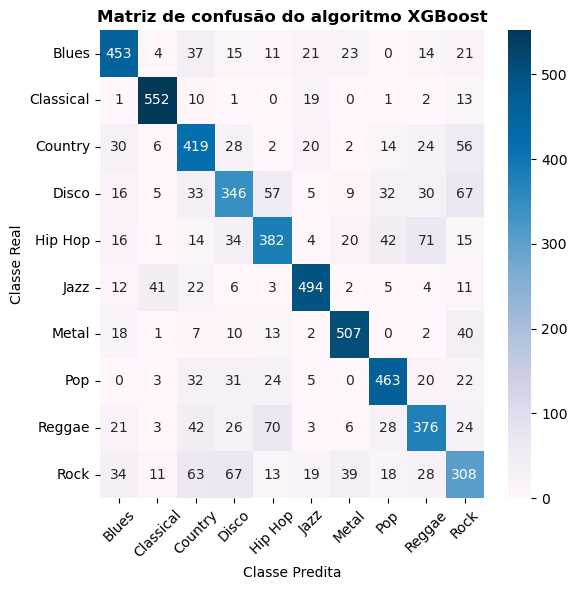

In [ ]:
conf_matrix = np.round(np.mean(xgb_matrix,axis=0))
conf_matrix

classes = ["Blues", "Classical", "Country", "Disco", "Hip Hop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

plt.figure(figsize=(6, 6))

sns.heatmap(conf_matrix, fmt=".0f", annot=True, cmap='PuBu',
            xticklabels=classes, yticklabels=classes, cbar=True)


# Ajusta os rótulos dos eixos
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")

# Título do gráfico
plt.title('Matriz de confusão do algoritmo XGBoost', fontweight='bold')

plt.tight_layout()

# Exibe o gráfico
plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/04_confusion_ptg.pdf')
plt.show()

In [ ]:
importance_means = np.mean(feat_import, axis=0)
features = ['Chroma médio C', 'Chroma desvio C','Chroma médio C#', 'Chroma desvio C#', 'Chroma médio D', 'Chroma desvio D', 'Chroma médio D#', 'Chroma desvio D#',
             'Chroma médio E', 'Chroma desvio E', 'Chroma médio F', 'Chroma desvio F', 'Chroma médio F#', 'Chroma desvio F#', 'Chroma médio G', 'Chroma desvio G',
             'Chroma médio Ab', 'Chroma desvio Ab', 'Chroma médio A', 'Chroma desvio A', 'Chroma médio Bb', 'Chroma desvio Bb', 'Chroma médio B', 'Chroma desvio B',
             'RMS médio', 'RMS desvio', 'SpC médio', 'SpC desvio', 'SpBw médio', 'SpBw desvio', 'SpR99 médio', 'SpR99 desvio', 'SpR01 médio', 'SpR01 desvio', 'ZCR médio',
             'ZCR desvio', 'MFCC1 médio', 'MFCC1 desvio', 'MFCC2 médio', 'MFCC2 desvio', 'MFCC3 médio', 'MFCC3 desvio', 'MFCC4 médio', 'MFCC4 desvio', 'MFCC5 médio',
             'MFCC5 desvio', 'MFCC6 médio', 'MFCC6 desvio', 'MFCC7 médio', 'MFCC7 desvio', 'MFCC8 médio', 'MFCC8 desvio', 'MFCC9 médio', 'MFCC9 desvio', 'MFCC10 médio',
             'MFCC10 desvio', 'MFCC11 médio', 'MFCC11 desvio', 'MFCC12 médio', 'MFCC12 desvio', 'MFCC13 médio', 'MFCC13 desvio', 'MFCC14 médio', 'MFCC14 desvio', 'MFCC15 médio',
             'MFCC15 desvio', 'MFCC16 médio', 'MFCC16 desvio', 'MFCC17 médio', 'MFCC17 desvio', 'MFCC18 médio', 'MFCC18 desvio', 'MFCC19 médio', 'MFCC19 desvio', 'MFCC20 médio',
             'MFCC20 desvio']

cmap = ['blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet',
        'blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet','blueviolet',
        'crimson', 'crimson', 'mediumspringgreen','mediumspringgreen','mediumspringgreen','mediumspringgreen','mediumspringgreen','mediumspringgreen','mediumspringgreen',
        'mediumspringgreen','crimson','crimson','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue',
        'deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue',
        'deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue',
        'deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue','deepskyblue']

mask = importance_means > 0.01

# Aplica a máscara para filtrar as listas antes de ordenar
filtered_importance_means = importance_means[mask]
filtered_features = [features[i] for i in np.where(mask)[0]]
filtered_cmap = [cmap[i] for i in np.where(mask)[0]]

# Ordena os elementos filtrados
sorted_indices = np.argsort(filtered_importance_means)

sorted_importances = [filtered_importance_means[i] for i in sorted_indices]
sorted_features = [filtered_features[i] for i in sorted_indices]
sorted_cmap = [filtered_cmap[i] for i in sorted_indices]

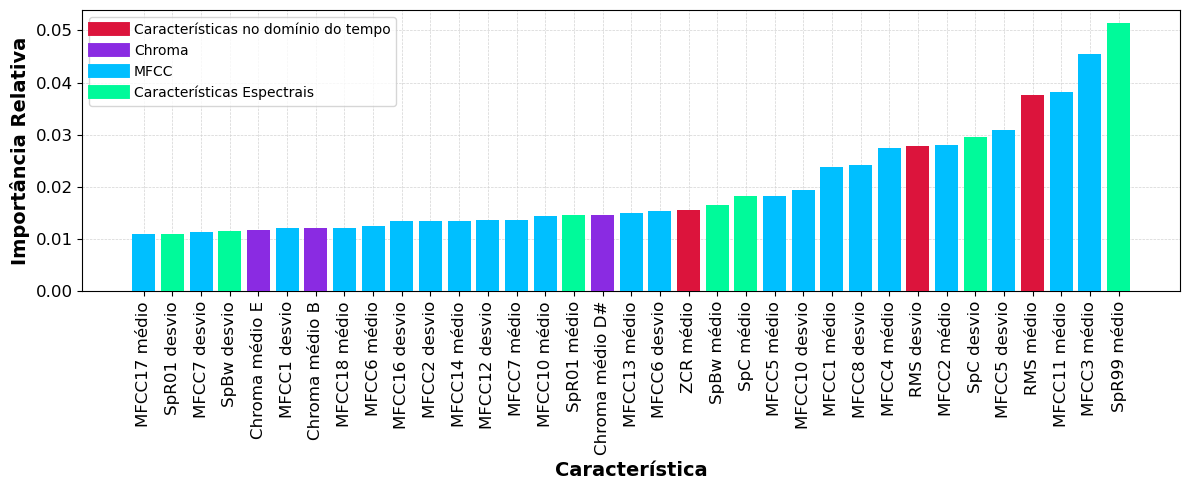

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

bars = ax.bar(sorted_features, sorted_importances, color=sorted_cmap, zorder=3)

categories = ['Características no domínio do tempo', 'Chroma', 'MFCC', 'Características Espectrais']
category_colors = ['crimson', 'blueviolet', 'deepskyblue', 'mediumspringgreen']
patches = [plt.Line2D([0], [0], color=color, lw=10) for color in category_colors]

ax.legend(patches, categories, loc='upper left')


# Adicionando títulos e rótulos
ax.set_xlabel('Característica', fontsize=14, fontweight='bold')
ax.set_ylabel('Importância Relativa', fontsize=14, fontweight='bold')
# ax.set_title('Features Importance for XGB', fontweight='bold', fontsize=18)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.grid(True, zorder=0)

plt.tight_layout()


plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/04_importance_ptg.pdf')
plt.show()

In [ ]:
np.sum(sorted_importances)

1.0000000028824434

In [ ]:
dflist[0].head()

,Chroma mean C,Chroma sd2 C,Chroma mean C#,Chroma sd2 C#,Chroma mean D,Chroma sd2 D,Chroma mean D#,Chroma sd2 D#,Chroma mean E,Chroma sd2 E,...,MFCC17 mean,MFCC17 sd2,MFCC18 mean,MFCC18 sd2,MFCC19 mean,MFCC19 sd2,MFCC20 mean,MFCC20 sd2,tempo,Classe
0,0.394617,0.105338,0.443642,0.088150,0.481578,0.101544,0.346441,0.061531,0.370519,0.082360,...,5.050471,36.993397,-8.289567,33.612530,-2.478076,38.674590,-2.092990,34.718590,123.046875,0
1,0.428290,0.113275,0.476215,0.106603,0.494223,0.107198,0.379621,0.076511,0.357802,0.066731,...,6.498300,29.181923,-3.217815,54.156834,3.200929,68.362210,0.460429,26.820696,123.046875,0
2,0.357212,0.096538,0.378870,0.071623,0.492932,0.101273,0.352712,0.061301,0.321471,0.066488,...,4.673268,32.282803,-7.692242,36.558690,0.692331,38.365930,0.794478,35.058080,123.046875,0
3,0.395143,0.086771,0.413099,0.078591,0.496900,0.105141,0.345685,0.054382,0.359460,0.067951,...,4.546683,32.767582,-5.488396,24.877170,1.453244,28.945955,-0.223831,27.314598,129.199219,0
4,0.405898,0.121835,0.433755,0.109411,0.463097,0.106878,0.305630,0.067156,0.281570,0.061102,...,5.317678,26.526995,-4.582438,36.219418,2.514524,36.389427,-0.436270,27.635517,123.046875,0


## Conf Matrix CNN

In [ ]:
df2 = pd.read_pickle("C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/results/performances_vgg16_new.pkl")

In [ ]:
conf_cnn = df2['conf_matrix'].values
conf_cnn

array([array([[349.,   6.,  71.,  47.,   3.,  34.,  16.,   1.,  31.,  42.],
              [  4., 527.,  20.,   5.,   0.,  35.,   1.,   0.,   2.,   6.],
              [ 22.,  11., 425.,  38.,   1.,  20.,   5.,  22.,  20.,  36.],
              [ 23.,   3.,  45., 346.,  20.,   9.,   1.,  53.,  62.,  38.],
              [ 11.,   0.,  13.,  65., 326.,   3.,  29.,  53.,  84.,  16.],
              [ 28.,  37.,  54.,  13.,   2., 426.,   5.,  14.,   5.,  16.],
              [ 11.,   1.,  12.,  11.,  18.,   3., 500.,   2.,   2.,  40.],
              [  0.,   2.,  56.,  52.,  19.,  12.,   2., 406.,  26.,  25.],
              [ 24.,   0.,  43.,  72.,  19.,   5.,   5.,  35., 370.,  27.],
              [ 34.,   3., 111.,  84.,  11.,  25.,  43.,  58.,  32., 199.]]),
       array([[360.,  11.,  21.,  39.,  11.,  62.,  15.,   1.,  17.,  63.],
              [  3., 535.,   6.,   2.,   0.,  42.,   3.,   0.,   2.,   7.],
              [ 24.,  16., 349.,  32.,   2.,  44.,   8.,  13.,  16.,  96.],
          

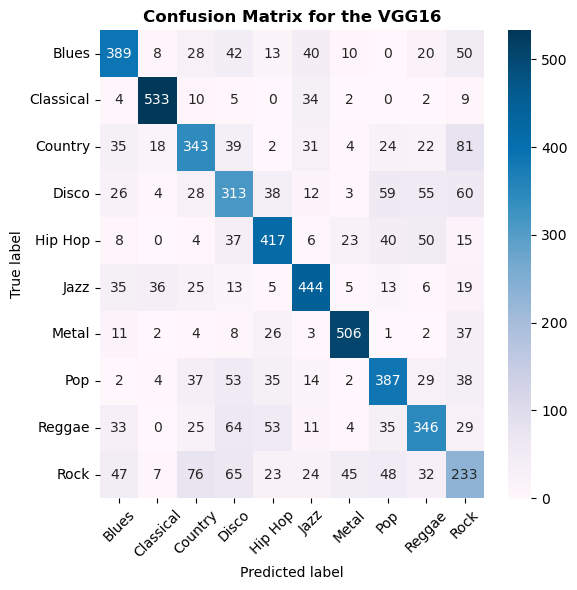

In [ ]:
cnn_matrix = np.round(np.mean(conf_cnn,axis=0))
cnn_matrix

classes = ["Blues", "Classical", "Country", "Disco", "Hip Hop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

plt.figure(figsize=(6, 6))

sns.heatmap(cnn_matrix, fmt=".0f", annot=True, cmap='PuBu',
            xticklabels=classes, yticklabels=classes, cbar=True)


# Ajusta os rótulos dos eixos
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.xlabel("Predicted label")
plt.ylabel("True label")

# Título do gráfico
plt.title('Confusion Matrix for the VGG16', fontweight='bold')

plt.tight_layout()

# Exibe o gráfico
plt.savefig('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/ft2/5s/04_confusion_teste.pdf')
plt.show()